In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('FB.csv')
df.set_index('Date', inplace= True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,101.949997,102.239998,99.750000,102.220001,102.220001,37912400
2016-01-05,102.889999,103.709999,101.669998,102.730003,102.730003,23258200
2016-01-06,101.129997,103.769997,100.900002,102.970001,102.970001,25096200
2016-01-07,100.500000,101.430000,97.300003,97.919998,97.919998,45172900
2016-01-08,99.879997,100.500000,97.029999,97.330002,97.330002,35402300


In [3]:
EMA = pd.DataFrame(index=df.index)
EMA = df[['Close']][0:].copy()  #copy Close price from df to EMA df
EMA['EMA12'] = EMA['Close'].ewm(12).mean() #12 period moving average
EMA['EMA26'] = EMA['Close'].ewm(26).mean() #26 period moving average

In [4]:
for i, row in EMA.iterrows():
    if EMA.loc[i,'EMA12'] < EMA.loc[i,'EMA26']:
        EMA.loc[i,'NEGATIVE'] = EMA.loc[i,'EMA12']
    elif EMA.loc[i,'EMA12'] > EMA.loc[i,'EMA26']: 
        EMA.loc[i,'POSITIVE'] = EMA.loc[i,'EMA12']
        
for i, row in EMA.iterrows():
    if (abs(EMA.loc[i,'EMA26']-EMA.loc[i,'EMA12']))<0.005*(EMA['EMA12'].max()-EMA['EMA12'].min()): # Cross over signal when the difference of EMA less than 0.5% of EMA12 range
        EMA.loc[i,'CROSSOVER']= EMA.loc[i,'EMA26']

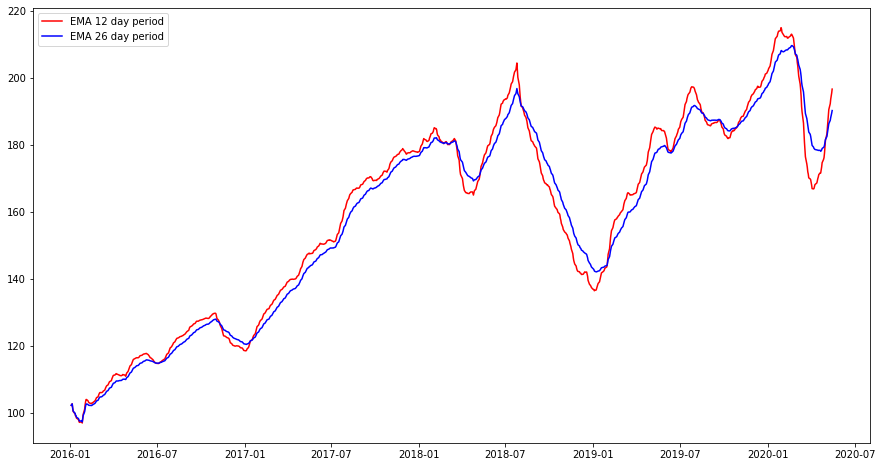

In [5]:
import datetime as dt
x = [dt.datetime.strptime(date,'%Y-%m-%d').date() for date in EMA.index]

plt.figure(figsize=(15,8))
plt.plot(x, EMA['EMA12'], label='EMA 12 day period', color = 'red')
plt.plot(x, EMA['EMA26'].values, label='EMA 26 day period', color='blue')
plt.legend(loc='upper left')
plt.show()

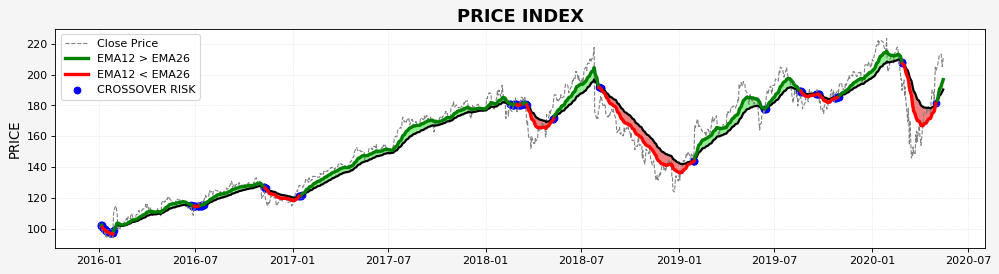

In [6]:
import datetime as dt

fig = plt.figure(figsize=(15,8),dpi=80,facecolor='whitesmoke') # fig size = 20x10 inches/ 100 dots per inch
x = [dt.datetime.strptime(date,'%Y-%m-%d').date() for date in EMA.index] #convert x axis into datetime format

ax1 = fig.add_subplot(211)
ax1.set_title('PRICE INDEX',fontsize=16,weight='bold')

Close = EMA['Close'] 
EMA12 = EMA['EMA12']
EMA26 = EMA['EMA26']
POSSITIVE = EMA['POSITIVE']
NEGATIVE = EMA['NEGATIVE']

#plotting EMA, POSITIVE, NEGATIVE and CLOSE price
ax1.plot(x, Close,color="gray", linewidth=1.0, linestyle="--",label='Close Price') #plot Close Price against x axis
ax1.plot(x, EMA26,color="black", linewidth=2.0, linestyle="-") #plot EMA26 against x axis
ax1.plot(x, POSSITIVE,color="green", linewidth=3.0, linestyle="-",label='EMA12 > EMA26') #plot possitive EMA12 against x axis
ax1.plot(x, NEGATIVE,color="red", linewidth=3.0, linestyle="-",label='EMA12 < EMA26') #plot negative EMA12 against x axis

#plotting crossover
ax1.scatter(x, EMA['CROSSOVER'],color='blue',label='CROSSOVER RISK') # mark CROSSOVER RISK points
ax1.fill_between(x, EMA26, EMA12, where=EMA12>EMA26, facecolor='lightgreen') #highlight buy signal
ax1.fill_between(x, EMA26, EMA12, where=EMA12<EMA26, facecolor='lightcoral') #highlight sell signal

#plot settings
ax1.grid(color='lightgray', linestyle=':', linewidth=0.5)#set grid
ax1.set_ylim = (20000.0, 25000.0) # Set limits on y axis
ax1.set_ylabel('PRICE',fontsize=12) #set y-axis lebel
ax1.legend(loc='upper left') #set legand

In [7]:
MACD = pd.DataFrame(index=df.index) #create new dataframe for MACD
MACD = df[['Close']][0:].copy() #copy Close price from df to MACD
MACD['MACD']=EMA['EMA12']-EMA['EMA26'] #calculate MACD = 12 Day period - 26 Day period
MACD['SIGNAL']= MACD['MACD'].ewm(9).mean() #calculate signal - 9 Day period EMA of MACD
MACD['HIST']=MACD['MACD']-MACD['SIGNAL'] #calculate histogram

for i, row in MACD.iterrows():
    if MACD.loc[i,'HIST']>0:
        MACD.loc[i,'POSITIVE']=MACD.loc[i,'HIST']
    else:
        MACD.loc[i,'NEGATIVE']=MACD.loc[i,'HIST']

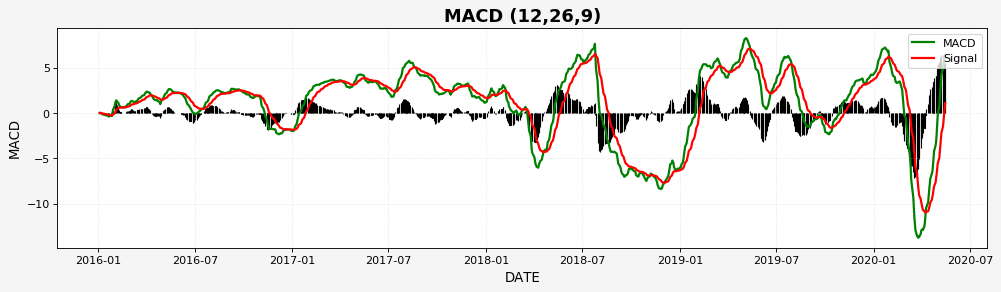

In [8]:
import datetime as dt

fig = plt.figure(figsize=(15,8),dpi=80,facecolor='whitesmoke')
x = [dt.datetime.strptime(date,'%Y-%m-%d').date() for date in EMA.index] #convert x axis into datetime format

ax1 = fig.add_subplot(212)
ax1.set_title('MACD (12,26,9)',fontsize=16,weight='bold')
ax1.bar(x, MACD['POSITIVE'],width=200/len(EMA), color="lightgreen",align='center',edgecolor='black')#plus histogram 
ax1.bar(x, MACD['NEGATIVE'],width=200/len(EMA), color="lightcoral",edgecolor='black')#minus histogram
ax1.plot(x, MACD['MACD'],color="green", linewidth=2.0, linestyle="-",label='MACD') #plot MACD
ax1.plot(x, MACD['SIGNAL'],color="red", linewidth=2.0, linestyle="-",label='Signal') #plot signal

#settings for plot
ax1.grid(color='lightgray', linestyle=':', linewidth=0.5)#set grid
ax1.set_ylabel('MACD',fontsize=12) #set y-axis lebel
ax1.set_xlabel('DATE',fontsize=12) #set x-axis lebel
ax1.legend(loc='upper right') #set legand

In [9]:
signal = MACD['SIGNAL']
macd = MACD['MACD']
LongShort = list();
for i in range(len(signal)):
    # If the MACD crosses the signal line upward
    if macd[i] > signal[i] and macd[i - 1] <= signal[i - 1]:
        LongShort.append("BUY")
    # 
    elif macd[i] < signal[i] and macd[i - 1] >= signal[i - 1]:
        LongShort.append("SELL")
    #                          # Do nothing if not crossed
    else:
        LongShort.append("HOLD")
MACD['Trading_Strategy'] = LongShort

In [10]:
buys = MACD.ix[(MACD['Trading_Strategy'] == 'BUY')]
sells = MACD.ix[(MACD['Trading_Strategy'] == 'SELL')]

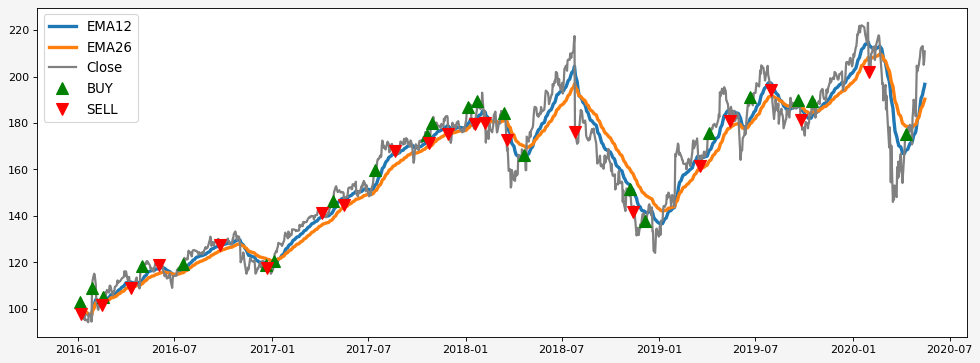

In [11]:
import datetime as dt

fig = plt.figure(figsize=(15,12),dpi=80,facecolor='whitesmoke') 

#create x-axis 
x = [dt.datetime.strptime(date,'%Y-%m-%d').date() for date in EMA.index]
x_buys = [dt.datetime.strptime(date,'%Y-%m-%d').date() for date in buys.index]
x_sells = [dt.datetime.strptime(date,'%Y-%m-%d').date() for date in sells.index]

#subplot
ax = fig.add_subplot(212)

#plot graphs
ax.plot(x, EMA['EMA12'], lw=3, label='EMA12')
ax.plot(x, EMA['EMA26'], lw=3, label='EMA26')
ax.plot(x, MACD['Close'], '-',lw=2, label='Close', color='grey')

#plot buy and sell tickers
ax.plot(x_buys, EMA.ix[buys.index]['Close'], '^', markersize=10, color='g', label='BUY')
ax.plot(x_sells, EMA.ix[sells.index]['Close'], 'v', markersize=10, color='r', label='SELL')
ax.legend(loc='upper left', fontsize=12)

In [41]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

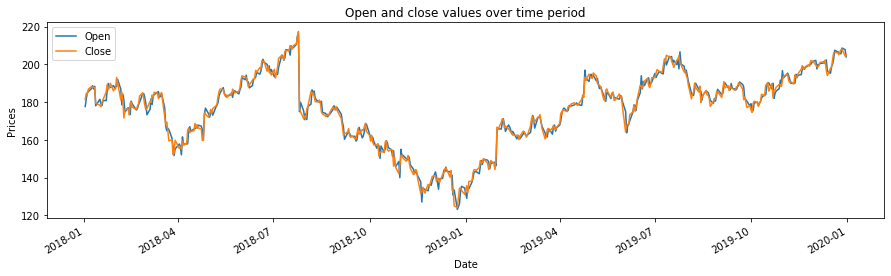

In [42]:
df.loc[df.index,['Open','Close']].plot(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Open and close values over time period')
plt.show()

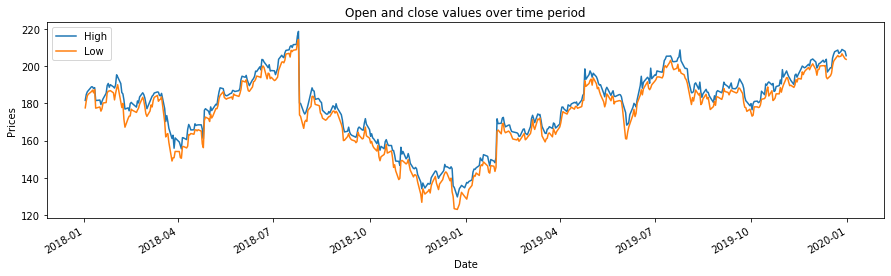

In [43]:
df.loc[df.index,['High','Low']].plot(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Open and close values over time period')
plt.show()

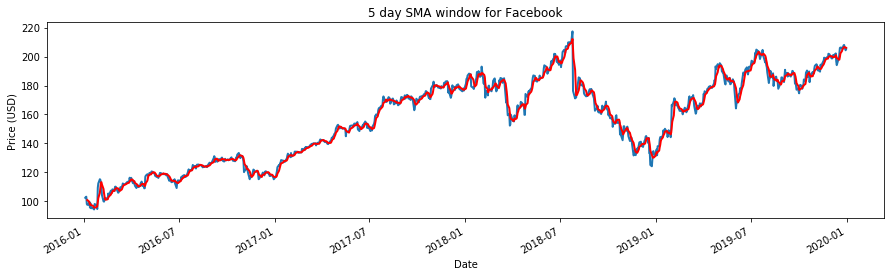

In [59]:
rolling = df.Close.rolling(window=5)
rolling_mean = rolling.mean()
df.Close.plot(figsize=(10,6), linewidth=2, fontsize=10)
rolling_mean.plot(figsize=(15,4), linewidth=2, fontsize=10, color='red')
plt.title('5 day SMA window for Facebook')
plt.ylabel('Price (USD)')
plt.show();

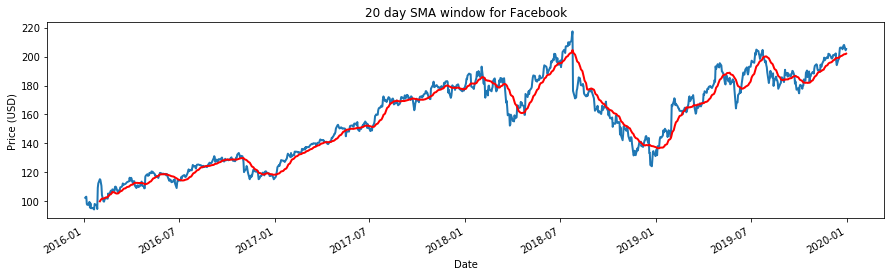

In [62]:
rolling = df.Close.rolling(window=20)
df['20_day_SMA'] = rolling.mean()
df.Close.plot(figsize=(15,4), linewidth=2, fontsize=10)
df['20_day_SMA'].plot(figsize=(15,4), linewidth=2, fontsize=10, color='red')
plt.title('20 day SMA window for Facebook')
plt.ylabel('Price (USD)')
plt.show();

In [55]:
mean = df['Close'].rolling(window=20).mean()
std = df.Close.rolling(window=20).std()
df['Upper_band'] = mean  + (std * 2)
df['Lower_band'] = mean - (std * 2)

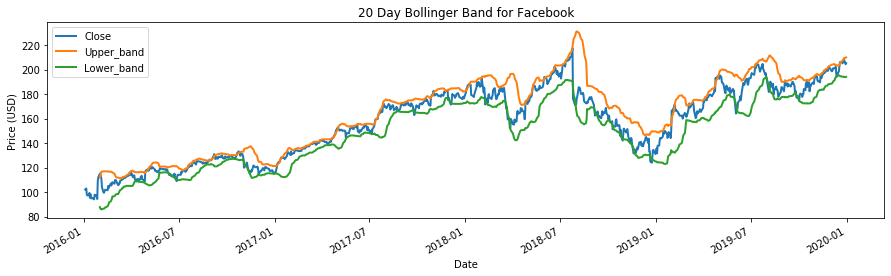

In [63]:
df[['Close','Upper_band','Lower_band']].plot(figsize=(15,4), linewidth=2, fontsize=10)
plt.title('20 Day Bollinger Band for Facebook')
plt.ylabel('Price (USD)')
plt.show();

In [2]:
# from pandas_datareader import DataReader
# from datetime import datetime
# import scipy.stats
# import pandas
# import matplotlib.pyplot as plt
# plt.style.use("bmh")
# %config InlineBackend.figure_formats=["png"]
# df = DataReader('FB',  'yahoo', datetime(2016,1,1), datetime(2019,12,31));
# returns = df["Close"].pct_change().dropna()
# mean = returns.mean()
# sigma = returns.std()
# tdf, tmean, tsigma = scipy.stats.t.fit(returns)
# returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)
# plt.title("Daily returns on FB", weight="bold");

In [3]:
# returns.quantile(0.05)

## Professionalism
50% Minghao Ru

50% Tong Yang


## Licensing
Copyright <2020> Minghao Ru, Tong Yang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.